In [228]:
from transformers import AutoTokenizer,AutoModelForCausalLM
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from captum.attr import Saliency
from numpy import random
import pandas as pd
import torch
from torch import nn, multinomial


In [229]:
tokenizer = AutoTokenizer.from_pretrained("../models/trained_moses_canonical_character_level/1/final_model")
model = AutoModelForCausalLM.from_pretrained("../models/trained_moses_canonical_character_level/1/final_model")
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(150, 256)
    (wpe): Embedding(60, 256)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-7): 8 x GPT2Block(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=768, nx=256)
          (c_proj): Conv1D(nf=256, nx=256)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=1024, nx=256)
          (c_proj): Conv1D(nf=256, nx=1024)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=256, out_features=150, bias=False)
)

In [3]:
def saliency_map_plot(scores,tokens,pred_token): 
    if len(scores)>=3:
        scores = scores[1:len(scores)-1]
        tokens = tokens[1:len(tokens)-1]

    max_score = torch.max(scores).item()  
    token_max_score_idx = []
    for k in range(len(scores)):
        if scores[k] >= 0.9*max_score:
            token_max_score_idx.append(k)
    tokens_adapted = ["" if k not in token_max_score_idx else tokens[k] for k in range(len(tokens)) ]
    fig, ax = plt.subplots(figsize=(20, 1))
   
    im = ax.imshow([scores.tolist()],cmap="viridis", data=tokens)
    ax.set_title('saliency map')
    fig.colorbar(im)

    plt.xticks([k for k in range(len(scores.tolist()))], tokens_adapted)

    ax.set_xlabel("saliency map for this token prediction : "+pred_token)

    

    
# 4. Forward personnalisé : utilise les embeddings au lieu de input_ids
def forward_func(embeds):
    outputs = model(inputs_embeds=embeds)
    # Prédiction du prochain token (dernier logit)
    return outputs.logits[:, -1, :]  # shape [1, vocab_size]


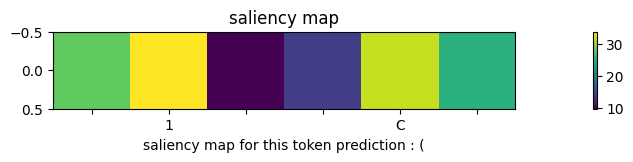

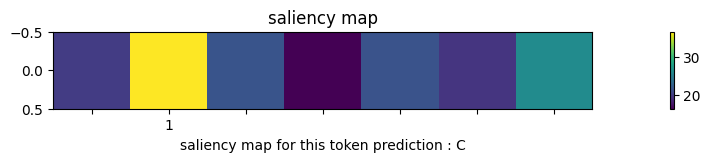

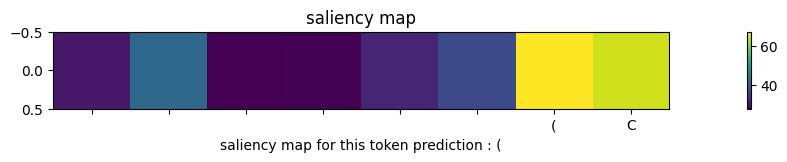

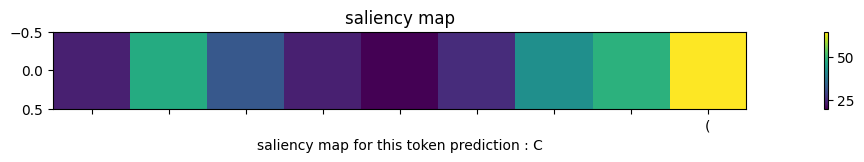

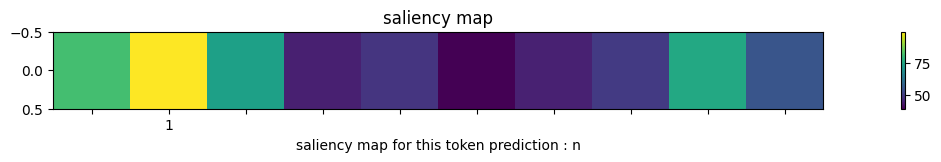

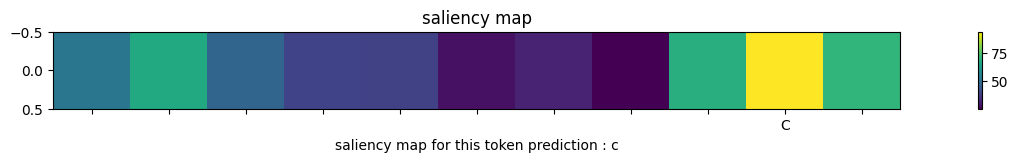

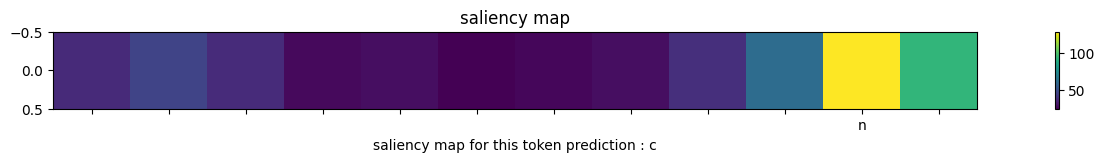

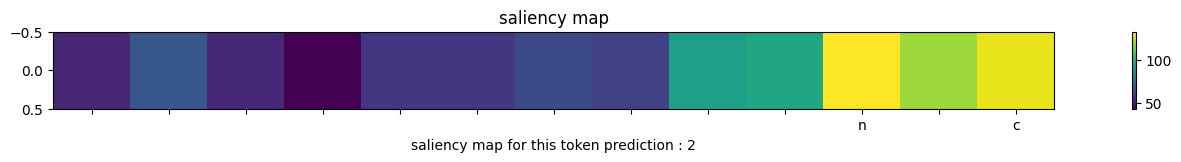

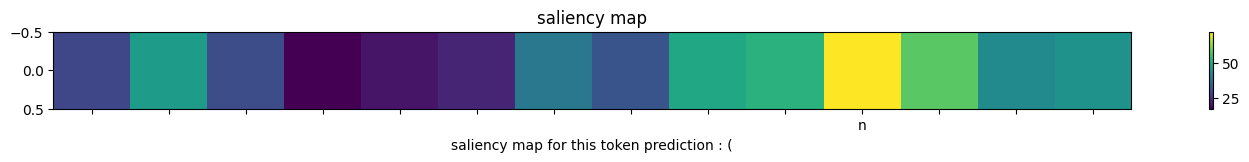

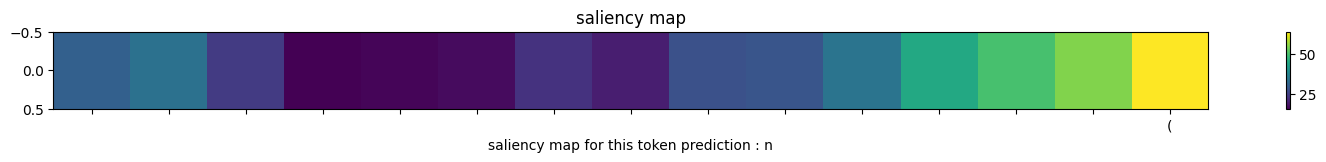

In [21]:

prompt = "C1CCCC"
for k in range(10):

    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"]
    inputs_embeds = model.transformer.wte(input_ids)
    #print(inputs_embeds.shape)
    #print(inputs_embeds.shape)
    inputs_embeds.requires_grad_()
    #prédiction du token suivant
    sf = torch.nn.Softmax(1)
    sf2 = torch.nn.Softmax(0)
    with torch.no_grad():
        out = model(input_ids=input_ids)
        #print(out.logits.shape)
        
        
        #probabilities = probabilities[0].tolist()
        #print(probabilities)
        
        
        #aléatoire et non déterministe (on prend pas le max mais on choisit une certaine distribution)
        probabilities = sf(out.logits[:, -1, :])
        pred_token_id = probabilities.multinomial(num_samples=1, replacement=True).item()


        #pred_token_id = torch.argmax(out.logits[:, -1, :], dim=-1).item()
        #print(pred_token_id)
        pred_token = tokenizer.decode([pred_token_id], skip_special_tokens=True)
        #print(f"Token prédit : '{pred_token}'")
        prompt += pred_token

    #Attribution avec Saliency
    saliency = Saliency(forward_func)
    attributions = saliency.attribute(inputs_embeds, target=pred_token_id, abs=True)
    """if k ==0:
        print(attributions.shape)
    """
    # 7. Affichage des scores par token
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    scores = attributions.sum(dim=-1).squeeze()# on somme sur les dimensions d'embedding
    #print(scores)
    #scores = sf2(scores)
    #print(attributions.shape)
    #print(scores.shape)
    saliency_map_plot(scores, tokens,pred_token=pred_token)


In [36]:
print(len(prompt))
prompt

16


'C1CCCC(C(Cccc2cn'

In [230]:
generated_ids = model.generate(
    max_length = tokenizer.model_max_length,
    num_return_sequences =1,
    pad_token_id = tokenizer.pad_token_id,
    bos_token_id = tokenizer.bos_token_id,
    eos_token_id = tokenizer.eos_token_id,
    do_sample = True,
    temperature = 1,
    return_dict_in_generate = True,
)

generated_smiles = tokenizer.decode(generated_ids["sequences"][0],skip_special_tokens=True)
len(generated_ids["sequences"])
generated_smiles = generated_smiles.replace(" ","")
generated_smiles

'Cn1cc(C(=O)NCc2ccc(F)cc2)c(=O)c2c(N)cccc21'

In [231]:
def saliency_map_plot(scores,tokens,pred_token): 
    

    max_score = torch.max(scores).item()  
    token_max_score_idx = []
    for k in range(len(scores)):
        if scores[k] >= 0*max_score:
            token_max_score_idx.append(k)
    tokens_adapted = ["" if k not in token_max_score_idx else tokens[k] for k in range(len(tokens)) ]
    fig, ax = plt.subplots(figsize=(20, 1))
   
    im = ax.imshow([scores.tolist()],cmap="viridis", data=tokens)
    ax.set_title('saliency map')
    fig.colorbar(im)

    plt.xticks([k for k in range(len(scores.tolist()))], tokens_adapted)

    ax.set_xlabel("saliency map for this token prediction : "+pred_token)

    

    
# 4. Forward personnalisé : utilise les embeddings au lieu de input_ids
def forward_func(embeds):
    outputs = model(inputs_embeds=embeds)
    # Prédiction du prochain token (dernier logit)
    return outputs.logits[:, -1, :]  # shape [1, vocab_size]


10
['C', 'n', '1', 'c', 'c', '(', 'C', '(', '=', 'O']
[36, 20, 146, 68, 68, 113, 36, 113, 37, 74]
32
[32, 36, 20, 146, 68, 68, 113, 36, 113, 37, 74]
torch.Size([1, 11, 150])
)
torch.Size([11])
11
Cn1cc(C(=O)NCc2ccc(F)cc2)c(=O)c2c(N)cccc21


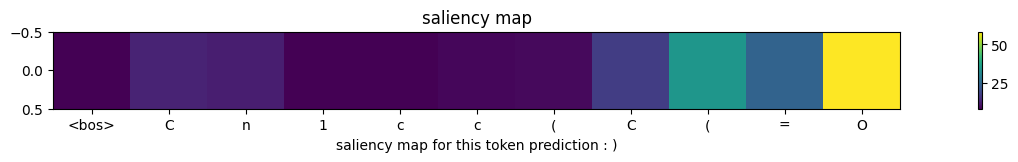

In [232]:

inputs_tokens = tokenizer.tokenize(generated_smiles, return_tensors="pt")


count = 0
for k in range(len(inputs_tokens)):
    if inputs_tokens[k] == ")":
        idx =k
        print(idx)
        count +=1
        if count == 1:
            break
        
        


sliced_inputs_tokens = inputs_tokens[:idx]
print(sliced_inputs_tokens)

inputs_ids = tokenizer.convert_tokens_to_ids(sliced_inputs_tokens)
begin = tokenizer.convert_tokens_to_ids("<bos>")
print(inputs_ids)
print(begin)
inputs_ids.insert(0,begin)
print(inputs_ids)

inputs_embeds = model.transformer.wte(torch.tensor([inputs_ids]))
custom_attention_mask = torch.tensor([[1]*(idx+1)])

#print(idx)
inputs_ids = torch.tensor([inputs_ids])
    #print(inputs_embeds.shape)
inputs_embeds.requires_grad_()
    #prédiction du token suivant
sf = torch.nn.Softmax(1)
sf2 = torch.nn.Softmax(0)


with torch.no_grad():
    out = model(input_ids=inputs_ids,attention_mask=custom_attention_mask)
    print(out.logits.shape)
    probabilities = sf(out.logits[:, -1, :])
    #print(out.logits.shape)
    #print(probabilities.shape)
    pred_token_id = probabilities.multinomial(num_samples=1, replacement=True).item()
    #pred_token_id = torch.argmax(out.logits[:, -1, :], dim=-1).item()
    
    print(tokenizer.convert_ids_to_tokens(pred_token_id))

    target_ids = tokenizer.convert_tokens_to_ids(")")
    

    saliency = Saliency(forward_func)
    attributions = saliency.attribute(inputs_embeds, target=target_ids, abs=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs_ids[0])
  
    scores = attributions.sum(dim=-1).squeeze()
    print(scores.shape)
    print(len(tokens))
    saliency_map_plot(scores, tokens,pred_token=")")
    print(generated_smiles)


In [239]:
scores.argmax()
tokens[scores.argmax()]

'O'